In [1]:
import numpy as np
import pandas as pd

from typing import Callable, NamedTuple, List, Iterable

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.animation as anime

In [2]:
# Logistic Iter
class Logistic(NamedTuple):
  plant_name: str
  n0: float
  K: float
  r: float
  
  def __call__(self, x:float) -> float:
    return self.r * x * (1 - x/self.K)
  
  def gen_term(self, t:float) -> float:
    return self.K / (1 + np.exp(-self.r * t) * (self.K / n0 - 1))

class LogisticIter():
  funcs: List[Callable[[float], float]]
  def __init__(self, plant_names: List[str], n0s: List[float], Ks:List[float], rs:List[float]):
    self.funcs = [Logistic(pn, n0, K, r) for pn, n0, K, r in zip(plant_names, n0s, Ks, rs)]
  
  def grow_field(self, field: np.ndarray, index: int) -> np.ndarray:
    return field + self.funcs[index](field)

In [3]:
# CAIter
class CAIter():
  def __init__(
    self,
    threshold: float = 10,
    buffer: int = 1,
    rule: Callable[[np.ndarray], np.ndarray] = None
  ):
    if rule is None:
      raise NotImplementedError('Set your own rule')

    self.rule = rule
    self.threshold = threshold
    self.buffer = buffer
    
  def detect_living(self, field:np.ndarray) -> np.ndarray:
    res = field.copy()
    res[res>=self.threshold] = 1
    res[res< self.threshold] = 0
    return res
  
  def align_field(self, field: np.ndarray) -> np.ndarray:
    b = self.buffer
    res = np.zeros_like(field)
    res[:, b:-b, b:-b] = field[:, b:-b, b:-b]
    return res
  
  def get_neighbors(self, field: np.ndarray) -> np.ndarray:
    f = self.detect_living(field)
    res = np.zeros_like(field)

    c = self.buffer
    b = 1 + self.buffer
    center = res[:,c:-c,c:-c]
    
    #up, down, left, right
    center += f[:, :-b,c:-c]
    center += f[:,b:  ,c:-c]
    center += f[:,c:-c, :-b]
    center += f[:,c:-c,b:  ]

    #lu, ld, ru, rd
    center += f[:, :-b, :-b]
    center += f[:,b:  , :-b]
    center += f[:, :-b,b:  ]
    center += f[:,b:  ,b:  ]
  
    return res
    
  def __call__(
    self,
    field:np.ndarray,
    pos_action: Callable[[np.ndarray, int], np.ndarray],
    neg_action: Callable[[np.ndarray, int], np.ndarray],
    regularize: Callable[[np.ndarray], np.ndarray]
  ) -> np.ndarray:
    assert field.ndim == 3, "Only Support 3-dim Tensor"
    
    currentf = self.detect_living(field)
    nextf = np.zeros_like(field)

    neighbor = self.get_neighbors(field)
    state = self.rule(currentf, neighbor)

    for i, (f, nxtf, s) in enumerate(zip(field, nextf, state)):
      nxtf[s] = pos_action(f[s], i)
      nxtf[~s]= neg_action(f[~s], i)
      
    nextf = regularize(nextf)
    
    return self.align_field(nextf)
  
  def print(self, field:np.ndarray) -> np.ndarray:
    return field.argmax(axis=0)

In [4]:
Rules = {
  '23/3': lambda old, new: (((old==0) & (new==3)) | ((old!=0) & ((new==2)|(new==3)))),
  '23/23': lambda old, new: ((new==2)|(new==3)),
}

def init_field(size: int, spec:int, buffer:int) -> np.ndarray:
  s = size + 2*buffer
  field = np.zeros((spec, s, s))
  return field

def set_random(field: np.ndarray, cpf: int, ran=[10,50], spec:int = 100) -> np.ndarray:
  spec, col, row = field.shape
  temp = field
  for _ in range(cpf):
    init_pos = np.hstack((
      np.arange(spec)[:, None],
      np.random.randint(1, col-1, (spec, 2))
    ))
    init_val = np.random.randint(ran[0], ran[1], (spec))
    temp[tuple(map(tuple, init_pos.T))] += init_val
  return temp

def run(field:np.ndarray, config:pd.DataFrame, n_iter:int = 30) -> np.ndarray:
  assert field.ndim == 3, "Only Support 3-dim Tensor"
  
  buffer = []
  caiter = CAIter(
    threshold = 1,
    buffer = 1,
    rule = Rules['23/3']
  )
  logiter = LogisticIter(
    plant_names = config.plant_name,
    n0s = config['n0'],
    Ks = config.K,
    rs = config.r
  )
  
  f = field
  for i in range(n_iter):
    f = caiter(
      field = f,
      pos_action = logiter.grow_field,
      neg_action = lambda f, i: f * 0.75,
      regularize = lambda x: x
    )
    buffer.append(f)
  return buffer, caiter, logiter

In [5]:
## setup
field = init_field(50, 100, 1)
field = set_random(field, 300)

db = pd.read_csv('plants_sample_param.csv')
db['scale'] = ((db.K / db.K.max()) * 100).round()

fields, caiter, logiter = run(field, db)

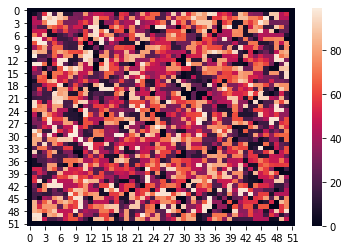

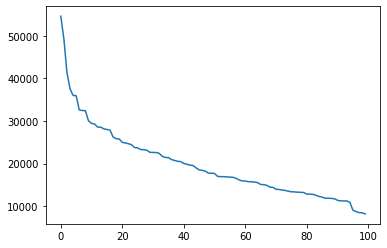

In [6]:
sns.heatmap(caiter.print(fields[29]))
plt.show()

plt.plot(np.sort(fields[10].sum(axis=2).sum(axis=1))[::-1])
plt.show()

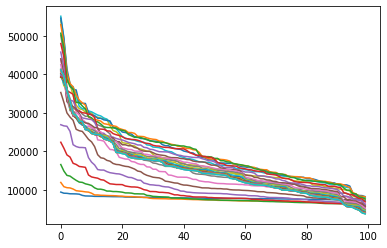

In [7]:
hoge = [np.sort(i.sum(axis=2).sum(axis=1))[::-1] for i in fields]
fig = plt.figure()

ims = []

for t in hoge:
        im = plt.plot(t)             # 乱数をグラフにする
        ims.append(im)                  # グラフを配列 ims に追加

# 10枚のプロットを 100ms ごとに表示
ani = anime.ArtistAnimation(fig, ims, interval=100)
plt.show()
ani.save("output.gif")